In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pandas as pd
import numpy as np
import csv
import networkx as nx
import time
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
from google.colab import files

In [6]:
uploaded_files = files.upload()

Saving correct&incorrect_proofs .csv to correct&incorrect_proofs  (1).csv


In [3]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Coder-1.5B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-Coder-1.5B")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

In [4]:
model.to('cuda')

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qw

## Upload correct proofs dataset

In [ ]:
df = pd.read_csv('data2.csv')
df.head()

,correct,statement
0,1,theorem coeLinearMap_eq_dfinsupp_sum [Decidabl...
1,1,theorem support_of_subset [∀ (i : ι) (x : β i)...
2,1,theorem of_eq_of_ne (i j : ι) (x : β i) (h : i...
3,1,theorem exists_mem_finset_dvd (hp : Prime p) {...
4,1,theorem exists_mem_finset_dvd (hp : Prime p) {...


## Generate some incorrect proofs

In [ ]:
n = len(df)
for i in range(n):
  statement = df['statement'][i]
  encoded_input = tokenizer(statement[len(statement) // 3], return_tensors='pt')
  output = model.generate(**encoded_input.to('cuda'),
                        repetition_penalty=1.5,
                        return_dict_in_generate=True)
  incorrect_statement = tokenizer.decode(output.sequences[0])
  row = pd.DataFrame({'correct': [0], 'statement': [incorrect_statement]})
  df = pd.concat([df, row], ignore_index=True)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


In [ ]:
df.to_csv('correct&incorrect_proofs.csv', index=False)
files.download('correct&incorrect_proofs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model proofs evaluation

In [9]:
df = pd.read_csv("correct&incorrect_proofs .csv")

In [13]:
n_layers = 28
n_heads = 12
l_q = []
for i in range(n_layers):
  for j in range(n_heads):
    l_q.append(f'{i} {j}')

columns = ['statement', 'true'].append(l_q)


mtd0_df = pd.DataFrame(columns=columns)

In [11]:
def mtd0(L, attentions, n_input, n):
  scores = {}
  att_adjs = torch.zeros((n_heads, n, n), device='cuda')

  for i in range(n_input, n):
    for j in range(i):
      att_adjs[:, i, j] = 1 - attentions[i - n_input][L][0][:, -1, j]
  att_adjs = (att_adjs + att_adjs.transpose(1, 2)) / 2.0  #symmetrization

  for Q, att_adj in enumerate(att_adjs):
    G = nx.from_numpy_array(att_adj.cpu().numpy())
    T = nx.minimum_spanning_tree(G)
    sum_weight = 0
    for edge in sorted(T.edges(data=True)):
      sum_weight += edge[2]['weight']

    scores[f"{L} {Q}"] = sum_weight / (n - n_input)

  return scores

In [12]:
def all_mtd0(attentions, n_input, n):
  scores = {}
  for L in range(n_layers):
    print(f"  counting for {L}. Time: {time.time()}")
    scores.update(mtd0(L, attentions, n_input, n))

  return scores

In [62]:
for i in range(26, 28): #len(df)):
  row = {}
  statement = df['statement'][i]
  print(statement)
  prompt = f"Continue the code in {statement}. The continuation: " #statement begins with 'Lean4:'
  encoded_input = tokenizer(prompt, return_tensors='pt')
  print(f"{i} generation begins. Time: {time.time()}")
  output = model.generate(**encoded_input.to('cuda'), max_new_tokens=50,
                          repetition_penalty=1.5, output_attentions=True,
                          return_dict_in_generate=True)
  print(tokenizer.decode(output.sequences[0]))
  print(f"Counting mtd0 begins. Time: {time.time()}")
  output_text = tokenizer.decode(output.sequences[0])
  row = all_mtd0(output.attentions, len(encoded_input.input_ids[0]), len(output.sequences[0]))
  row['true'] = df['correct'][i]
  row['statement'] = i
  mtd0_df = pd.concat([mtd0_df, pd.DataFrame(row, index=[0])], ignore_index=True)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Lean4: @[scoped simp]\ntheorem map_add_nsmul [AddMonoid G] [AddMonoid H]     [AdjointedRing R, AddCommGroup (R ×)]\nsimp\n@[simp]: theorem add_map_mul_left_cancel_iff : ∀ a b c d e f g h k l m n o p q r s t u v w x y z,\na + ((b * 1) • (((c -d)*e)*(f•g))) =   \nb*(((a-((x*y)+(z*w)))+((((y*z)-(w*x))+u)-v))*h)=    \\begin{array}{ll} &\\text{}\\\\&0=2+3*(5∗6)=(7−8)(9⋅(​ ​ ))=(…)\t\t\\\end { array}\nTheorem of the Week:\nto be determined.\nclass adjoint_ring := Adjointed Ring.
26 generation begins. Time: 1734719220.4862385
Continue the code in Lean4: @[scoped simp]\ntheorem map_add_nsmul [AddMonoid G] [AddMonoid H]     [AdjointedRing R, AddCommGroup (R ×)]\nsimp\n@[simp]: theorem add_map_mul_left_cancel_iff : ∀ a b c d e f g h k l m n o p q r s t u v w x y z,\na + ((b * 1) • (((c -d)*e)*(f•g))) =   \nb*(((a-((x*y)+(z*w)))+((((y*z)-(w*x))+u)-v))*h)=    \\begin{array}{ll} &\\text{}\\\\&0=2+3*(5∗6)=(7−8)(9⋅(​ ​ ))=(…)\t\t\\\end { array}\nTheorem of the Week:\nto be determined.\nclass adjoint_

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Lean4: theorem map_ofNat_add' [AddCommMonoidWithOne G] [AddMonoid H] [Add    MonoidalCategory M]
  by (simp add : Add_monoids.map_map)
```
```   15.2 +lemma nat_sum_eq_0_iff_nat_prod_neq_zero:
-      "natSum f = zero \<longleftrightarrow> (\<exists>x y :: 'a::semiring'. x * Suc(y) -|= r & sumOfList ((f o fst)) [] =
+     "(\<forall>a b c d e z w.
       let
         a, s as <b,c,d,e,z,w>
           |<x,y>_ := Nat.sum_list_as_fst g h i j k l m n p q

(* TODO *)
-
-*}
+
*)
(** Theorem for the case where we have an explicit list of pairs and not just one pair *)

@@@ /src/HOL/Analysis/Natural_Numbers.thy        (3689 vs        e7dcbbe)

• (* FIXME *) lemma prod_leI:

--- NEW FILE ---
+++ HOL/ex/Lemmas.ML        Tue Mar     
27 generation begins. Time: 1734719271.5369866
Continue the code in Lean4: theorem map_ofNat_add' [AddCommMonoidWithOne G] [AddMonoid H] [Add    MonoidalCategory M]
  by (simp add : Add_monoids.map_map)
```
```   15.2 +lemma nat_sum_eq_0_iff_nat_prod_neq_zero:
-      "

In [17]:
output_text

"Continue the code in Lean4: theorem map_ofNat_add' [AddCommMonoidWithOne G] [AddMonoid H] [Add    ConstMapClass F G H 1 b]\\n    (f : F) (n : ℕ) [n.AtLeastTwo] (x : G) :\\n        f (OfNat.ofNat n + x) = f x + OfNat.ofNat n • b :=\\n  map_nat_add' f n x\\ntheorem add_map_const {G}:\\nTheorem of Nat Add Comm Mon Group with One and a constant function is commutative.\\nto prove that for any two natural numbers, their sum plus one times some other number equals to this same"

In [19]:
mtd0_df.to_csv('exp2.csv', index=False)
files.download('exp2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Choosing the best head

In [22]:
mtd0_df = pd.read_csv('exp2.csv')

In [23]:
mtd0_df.head()

,0 0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,...,27 4,27 5,27 6,27 7,27 8,27 9,27 10,27 11,true,statement
0,2.129709,1.895439,2.098381,2.147059,2.168204,2.016115,1.799098,1.949348,1.850728,2.068990,...,2.185272,2.188072,2.176431,2.200794,2.183536,2.205482,1.898788,2.167924,1,0
1,1.958110,1.708592,1.875634,1.887097,1.958517,1.830394,1.564664,1.787356,1.645737,1.896482,...,1.963492,1.964238,1.954340,1.955924,1.951184,1.955144,1.653436,1.960870,1,1
2,2.129709,1.895439,2.098381,2.147059,2.168204,2.016115,1.799098,1.949348,1.850728,2.068990,...,2.185272,2.188072,2.176431,2.200794,2.183536,2.205482,1.898788,2.167924,1,0
3,1.958110,1.708592,1.875634,1.887097,1.958517,1.830394,1.564664,1.787356,1.645737,1.896482,...,1.963492,1.964238,1.954340,1.955924,1.951184,1.955144,1.653436,1.960870,1,1
4,1.381005,1.086784,1.264149,1.270002,1.403503,1.171507,0.980818,1.139630,1.053454,1.289553,...,1.402570,1.395101,1.390914,1.394534,1.379070,1.386694,1.102121,1.386195,1,2


In [35]:
true_df = mtd0_df[mtd0_df['true'] == 1][2:]
false_df = mtd0_df[mtd0_df['true'] == 0]

In [63]:
len(mtd0_df)

60

In [58]:
df['statement'][13], df['statement'][27]

('Lean4: theorem squashGCF_nth_of_lt {m : ℕ} (m_lt_n : m < n) :\\n    (squashGCF g (n + 1)).s.get? m = g.s.get? m := by\\n  simp only [squashGCF, squashSeq_nth_of_lt m_lt_n, Nat.add_eq, add_zero]',
 'Lean4: theorem map_ofNat_add\' [AddCommMonoidWithOne G] [AddMonoid H] [Add    MonoidalCategory M]\n  by (simp add : Add_monoids.map_map)\n```\n```   15.2 +lemma nat_sum_eq_0_iff_nat_prod_neq_zero:\n-      "natSum f = zero \\<longleftrightarrow> (\\<exists>x y :: \'a::semiring\'. x * Suc(y) -|= r & sumOfList ((f o fst)) [] =\n+     "(\\<forall>a b c d e z w.\n       let\n         a, s as <b,c,d,e,z,w>\n           |<x,y>_ := Nat.sum_list_as_fst g h i j k l m n p q\n\n(* TODO *)\n-\n-*}\n+\n*)\n(** Theorem for the case where we have an explicit list of pairs and not just one pair *)\n\n@@@ /src/HOL/Analysis/Natural_Numbers.thy        (3689 vs        e7dcbbe)\n\n• (* FIXME *) lemma prod_leI:\n\n--- NEW FILE ---\n+++ HOL/ex/Lemmas.ML        Tue Mar\xa0 \xa0\xa0\xa0')

In [64]:
mtd0_df[mtd0_df.columns][57:60]

,0 0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,...,27 4,27 5,27 6,27 7,27 8,27 9,27 10,27 11,true,statement
57,8.048250,7.779015,7.982215,8.187500,8.103281,7.720909,7.687820,7.779289,7.737436,8.029962,...,8.083128,8.072672,8.083928,8.093341,8.070456,8.071969,7.776384,8.087449,0,27
58,2.461104,2.100793,2.368116,2.130028,2.456047,2.277925,2.040185,2.220574,2.104461,2.421786,...,2.460556,2.458607,2.463914,2.471721,2.469555,2.429188,2.140442,2.458888,0,26
59,3.318621,3.029921,3.221826,3.152149,3.356225,3.153280,2.930412,3.109252,3.015070,3.308138,...,3.338159,3.327613,3.307904,3.325529,3.294891,3.314610,3.124435,3.322746,0,27


In [40]:
false_df.head()

,0 0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,...,27 4,27 5,27 6,27 7,27 8,27 9,27 10,27 11,true,statement
27,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,...,41.5,41.5,41.5,41.5,41.5,41.5,41.5,41.5,0,25
28,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0,26
29,123.0,123.0,123.0,123.0,123.0,123.0,123.0,123.0,123.0,123.0,...,123.0,123.0,123.0,123.0,123.0,123.0,123.0,123.0,0,27
30,32.5,32.5,32.5,32.5,32.5,32.5,32.5,32.5,32.5,32.5,...,32.5,32.5,32.5,32.5,32.5,32.5,32.5,32.5,0,28
31,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,...,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,0,29


In [36]:
true_means = true_df[l_q].mean()
false_means = false_df[l_q].mean()

In [37]:
len(mtd0_df)

52

In [38]:
len(true_df), len(false_df)

(25, 25)

In [39]:
means_diff = np.abs(true_means - false_means)
means_diff.head()

,0
0 0,83.404330
0 1,83.523400
0 2,83.445287
0 3,83.451378
0 4,83.402385


In [ ]:
true_df[l_q].head()

,0 0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,...,23 4,23 5,23 6,23 7,23 8,23 9,23 10,23 11,23 12,23 13
1,7.428437,6.721555,7.604756,7.646856,7.117545,6.860174,7.480135,6.781923,7.620415,7.396265,...,6.963192,7.554138,7.506504,7.541316,7.524051,7.540761,7.503885,7.537954,7.439744,7.519286
2,7.429215,6.741433,7.613970,7.660134,7.148560,6.876287,7.447622,6.781566,7.649968,7.397986,...,7.026193,7.567004,7.363850,7.581297,7.556912,7.575531,7.577854,7.570592,7.503492,7.581471
5,8.092127,7.361066,8.250828,8.284596,7.752490,7.496954,8.066984,7.394812,8.271554,8.051429,...,7.615617,8.054924,7.982897,8.053394,8.097684,8.089702,8.109141,8.092665,8.053856,8.128797
9,4.157065,3.810464,4.254595,4.270765,4.038761,3.901207,4.179719,3.824546,4.262135,4.148917,...,3.950026,4.240699,4.186225,4.227625,4.216406,4.216230,4.228367,4.214575,4.201333,4.243353
16,4.533352,4.180487,4.622434,4.638365,4.386881,4.242726,4.535885,4.218857,4.626780,4.519720,...,4.308750,4.597274,4.502648,4.557855,4.572887,4.562129,4.583901,4.548406,4.557461,4.588705


In [ ]:
false_df[l_q].head()

,0 0,0 1,0 2,0 3,0 4,0 5,0 6,0 7,0 8,0 9,...,23 4,23 5,23 6,23 7,23 8,23 9,23 10,23 11,23 12,23 13
0,8.402538,7.693599,8.551961,8.599784,8.086297,7.788137,8.416353,7.743493,8.594426,8.370518,...,7.980570,8.504601,8.325837,8.538816,8.514880,8.515990,8.522953,8.516065,8.449208,8.519057
3,6.658518,5.941099,6.812885,6.859333,6.365332,6.068187,6.631812,6.011406,6.846573,6.611563,...,6.231899,6.766830,6.617912,6.804539,6.774409,6.767014,6.775797,6.785226,6.725798,6.770068
4,7.190400,6.481373,7.347241,7.397549,6.878568,6.588216,7.244138,6.525918,7.375958,7.158486,...,6.752281,7.250279,7.194132,7.335659,7.320223,7.314806,7.274478,7.312656,7.253214,7.316083
6,7.159304,6.421233,7.304912,7.336762,6.773704,6.528677,7.125625,6.502595,7.333640,7.110360,...,6.698642,7.213431,7.079972,7.090944,7.126033,7.098674,7.114993,7.090161,7.114791,7.170012
7,7.159304,6.421233,7.304912,7.336762,6.773704,6.528677,7.125625,6.502595,7.333640,7.110360,...,6.698642,7.213431,7.079972,7.090944,7.126033,7.098674,7.114993,7.090161,7.114791,7.170012


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

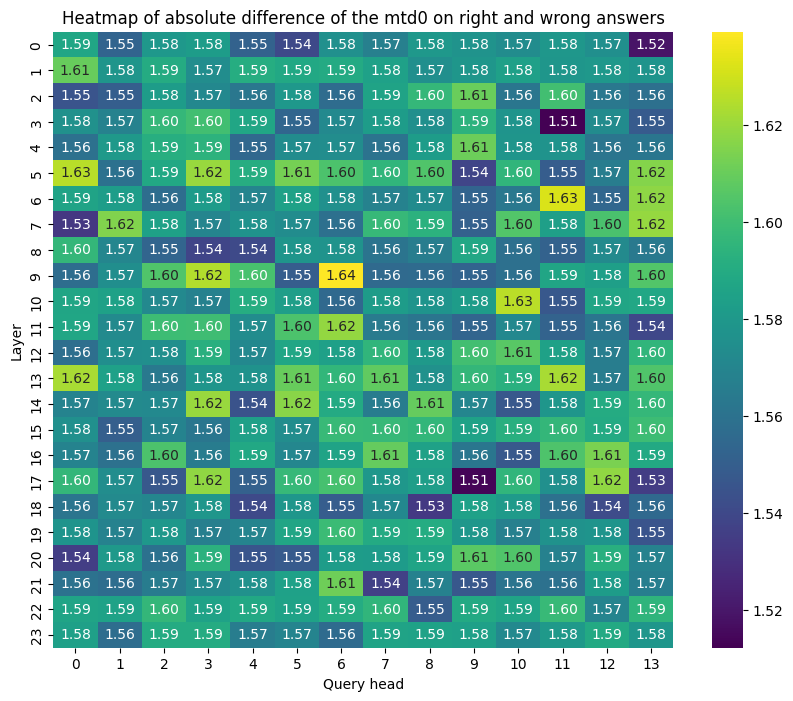

In [ ]:
reshaped_means = means_diff.values.reshape(n_layers, n_heads)
plt.figure(figsize=(10, 8))
sns.heatmap(reshaped_means, annot=True, fmt=".2f", cmap='viridis')
plt.title('Heatmap of absolute difference of the mtd0 on right and wrong answers')
plt.xlabel('Query head')
plt.ylabel('Layer')

plt.savefig('heatmap1.jpg', dpi=300)
files.download('heatmap1.jpg')

plt.show()